# Packages Installs, imports, and presets

In [1]:
from scapy.all import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import defaultdict
import os
import sklearn

import feature_engine
import feature_engine.encoding

import feature_engine.imputation
from constants import TIMEOUT, NUMBER_PACKETS_OPTIONS
import pandas as pd
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import constants

In [2]:
# df_train= pd.read_parquet('data/df_train_statistics.parquet')
# df_validation = pd.read_parquet('data/df_validation_statistics.parquet')
# df_test=pd.read_parquet('data/df_test_statistics.parquet')

In [3]:
# df_test=pd.read_parquet(f'data/iec104_train_statistics_{TIMEOUT}.parquet')

# for number_packets in NUMBER_PACKETS_OPTIONS:
#     print(df_test[(df_test['total_fpackets']+df_test['total_bpackets'])<=number_packets].shape)
    # if isinstance(number_packets,int):
    #     df = df[df['packet_number'].isin(list(range(number_packets)))]
    #     df = df.groupby(level='flow').filter(lambda x: len(x) <= number_packets)

In [4]:
# df_test=pd.read_parquet(f'data/iec104_test_statistics_{TIMEOUT}.parquet')
# df_test
# # df_test.drop('flow',axis=1)

In [5]:
def evaluate_model_performance(best_model, X_test, y_test,number_packets):
    # Predicting on the test set
    print("Evaluating model", best_model)
    y_pred = best_model.predict(X_test)
    
    # Calculating metrics
    accuracy = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    
    # Measuring prediction time
    prediction_times = []
    
    # Iterate over each sample in X_test
    # print(X_test)
    for idx in tqdm(range(len(X_test))):
    # for idx in tqdm(range(300)):
        sample = X_test.iloc[[idx]]  # Select a single sample as DataFrame
        # print(sample.shape)
        # display(sample)
    # for c,sample in X_test.iterrows():
        start_time = time.time()
        best_model.predict(sample)  # Predicting on a single sample
        end_time = time.time()
        
        # Calculate the duration for this sample
        duration = end_time - start_time
        prediction_times.append([duration, sample['computation_time'].iloc[0]])
    
    prediction_times = pd.DataFrame(prediction_times,columns=['duration','computation_time'])
    
    # Generating the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # print(prediction_times)
    # Calculating throughput and other metrics
    avg_pred_time = prediction_times['duration'].mean()
    std_pred_time = prediction_times['duration'].std()
    avg_throughput = 1/avg_pred_time
    std_throughput = (1/prediction_times['duration']).std()
    
    avg_total_pred_time = (prediction_times['duration']+prediction_times['computation_time']).mean()
    std_total_pred_time = (prediction_times['duration']+prediction_times['computation_time']).std()
    avg_total_throughput = 1/avg_total_pred_time
    std_total_throughput = (1/(prediction_times['duration']+prediction_times['computation_time'])).std()
    
    tp = np.diag(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)

    # Aggregate the scores
    tp_sum = np.sum(tp)
    fn_sum = np.sum(fn)
    fp_sum = np.sum(fp)
    tn_sum = np.sum(tn)

    # Compute micro-aggregated TPR and FPR
    tpr_micro = tp_sum / (tp_sum + fn_sum) if (tp_sum + fn_sum) != 0 else 0
    fpr_micro = fp_sum / (fp_sum + tn_sum) if (fp_sum + tn_sum) != 0 else 0
    metrics_dict = constants.metrics_log_formatter(name, grid_search.best_params_, number_packets, TIMEOUT,accuracy=accuracy, precision=precision, recall=recall, cm=cm,
                                  tpr_micro=tpr_micro, fpr_micro=fpr_micro, avg_pred_time=avg_pred_time,
                                  std_pred_time=std_pred_time, avg_throughput=avg_throughput,
                                  std_throughput=std_throughput, avg_total_pred_time=avg_total_pred_time,
                                  std_total_pred_time=std_total_pred_time, avg_total_throughput=avg_total_throughput,
                                  std_total_throughput=std_total_throughput)
    return metrics_dict

# TIMEOUT = 30
    # df_train_statistics.to_parquet(f'data/iec104_train_statistics_{TIMEOUT}_{number_packets}.parquet')

    # df_validation_statistics = get_flows_statistics(df_validation)
    # df_validation_statistics.to_parquet(f'data/iec104_validation_statistics_{TIMEOUT}_{number_packets}.parquet')

    # df_test_statistics = get_flows_statistics(df_test)
    # df_test_statistics.to_parquet(f'data/iec104_train_statistics_{TIMEOUT}_{number_packets}.parquet')
# for number_packets in NUMBER_PACKETS_OPTIONS:
df_train=pd.read_parquet(f'data/iec104_train_statistics_{TIMEOUT}.parquet')

df_validation=pd.read_parquet(f'data/iec104_validation_statistics_{TIMEOUT}.parquet')

df_test=pd.read_parquet(f'data/iec104_test_statistics_{TIMEOUT}.parquet')

NUM_CLASSES = df_train.label.nunique()

df_tests = dict()
for number_packets in NUMBER_PACKETS_OPTIONS:
    df_tests[number_packets] = pd.read_parquet(f'data/iec104_train_statistics_{TIMEOUT}_{number_packets}.parquet')
# df_train

# df_train=df_train.drop('flow',axis=1)
# df_validation=df_validation.drop('flow',axis=1)
df_validation=df_validation.drop('flow',axis=1)
df_train=df_train.drop('flow',axis=1)
df_test=df_test.drop('flow',axis=1)
for number_packets in NUMBER_PACKETS_OPTIONS:
    df_tests[number_packets].drop('flow',axis=1,inplace=True)



df_train.columns
tmp = df_train.dtypes
tmp.loc[tmp=='object']
oe = feature_engine.encoding.OrdinalEncoder(encoding_method='arbitrary')
df_train[['src','dst']]
oe.fit(df_train[['src','dst']])
df_train[['src','dst']]=oe.transform(df_train[['src','dst']])
df_validation[['src','dst']]=oe.transform(df_validation[['src','dst']])
df_test[['src','dst']]=oe.transform(df_test[['src','dst']])

for number_packets in NUMBER_PACKETS_OPTIONS:
    df_tests[number_packets][['src','dst']]=oe.transform(df_tests[number_packets][['src','dst']])
    
oe = feature_engine.encoding.OrdinalEncoder()
tmp = df_train.isnull().sum()
tmp.loc[tmp>0]
columns_with_nan_values = list(tmp.loc[tmp>0].index)

mmi = feature_engine.imputation.ArbitraryNumberImputer(arbitrary_number=0)
mmi.fit(df_train[columns_with_nan_values])

df_train[columns_with_nan_values]=mmi.transform(df_train[columns_with_nan_values])
df_test[columns_with_nan_values]=mmi.transform(df_test[columns_with_nan_values])
for number_packets in NUMBER_PACKETS_OPTIONS:
    df_tests[number_packets][columns_with_nan_values]=mmi.transform(df_tests[number_packets][columns_with_nan_values])
df_validation[columns_with_nan_values]=mmi.transform(df_validation[columns_with_nan_values])

X_train = df_train.loc[:,df_train.columns != 'label']
y_train = df_train.loc[:,df_train.columns == 'label'].to_numpy().flatten()
X_test = df_test.loc[:,df_test.columns != 'label']
y_test = df_test.loc[:,df_test.columns == 'label'].to_numpy().flatten()
X_tests= dict()
y_tests = dict()
# display(X_test)

for number_packets in NUMBER_PACKETS_OPTIONS:
    X_tests[number_packets] = df_tests[number_packets].loc[:,df_tests[number_packets].columns != 'label']
    y_tests[number_packets] = df_tests[number_packets].loc[:,df_tests[number_packets].columns == 'label'].to_numpy().flatten()
    
X_val = df_validation.loc[:,df_validation.columns != 'label']
y_val = df_validation.loc[:,df_validation.columns == 'label'].to_numpy().flatten()


In [12]:
X_train.shape, X_test.shape

((9757, 64), (2711, 64))

In [1]:

models = {
    # "Logistic Regression": (LogisticRegression(max_iter=1000), {
    #     'C': [0.1, 1, 10, 100],
    #     'solver': ['liblinear']
    # }),
    # "Linear Discriminant Analysis": (LinearDiscriminantAnalysis(), {
    #     'solver': ['svd', 'lsqr', 'eigen']
    # }),
    # "Quadratic Discriminant Analysis": (QuadraticDiscriminantAnalysis(), {
    #     'reg_param': [0.0, 0.1, 0.5, 1.0]
    # }),
    # "Naive Bayes": (GaussianNB(), {
    #     'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    # }),
    "Random Forest": (RandomForestClassifier(), {
        # 'n_estimators': [50, 100, 200],
        'n_estimators': [100],
        'max_features': ['sqrt'],
        # 'max_depth': [None, 10, 20, 30]
        'max_depth': [5]
    }),
    # "Adaboost": (AdaBoostClassifier(algorithm='SAMME'), {
    #     'n_estimators': [50, 200],
    #     'learning_rate': [0.01, 0.1]
    # }),
    # "MLP": (MLPClassifier(max_iter=1000), {
    # 'hidden_layer_sizes': [ (100,50,50)],
    # 'activation': ['tanh','relu'],
    # 'solver': [ 'lbfgs','adam'],
    # 'alpha': [0.0001],
    # 'learning_rate': [ 'adaptive']
    # }),
    # "Decision Tree": (DecisionTreeClassifier(), {
    #     'criterion': ['gini', 'entropy'],
    #     'max_depth': [None, 10, 20, 30]
    # }),
}

# Train and evaluate models using HalvingGridSearchCV
results = []
# NUM_RUNS = 20
for name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=16,verbose=3)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    # print(best_model)
    # best_model.set_params({'max_iter': 10000})
    # best_model.fit(X_train, y_train)
    if name == 'Random Forest':
        # print(best_model.feature_importances_)
        # print(X_train.columns)
        forest_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
        forest_importances = forest_importances.sort_values(ascending=False)

        # Plotting the feature importances
        display(forest_importances)
        # print(model.feature_importances_())
    # performance_metrics=constants.metadata_log_formatter(name, grid_search.best_params_, 'full', TIMEOUT)
    res = evaluate_model_performance(best_model, X_test, y_test,'full')
    # performance_metrics.update(res)
    results.append(res)
    
    for number_packets in NUMBER_PACKETS_OPTIONS:
        # performance_metrics = constants.metadata_log_formatter(name, grid_search.best_params_, number_packets, TIMEOUT)
        res = evaluate_model_performance(best_model, X_tests[number_packets], y_tests[number_packets],number_packets)
        # performance_metrics.update(res)
        results.append(res)

# Convert results to a DataFrame
df_results = pd.DataFrame(results)
# df_results['output_date'] = pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
# df_results['number_packets'] = number_packets
# df_results['timeout'] = TIMEOUT
output_path= 'data/results.json'
df_results.to_json(output_path, mode='a',orient="records", lines=True)#, header=not os.path.exists(output_path))

NameError: name 'RandomForestClassifier' is not defined

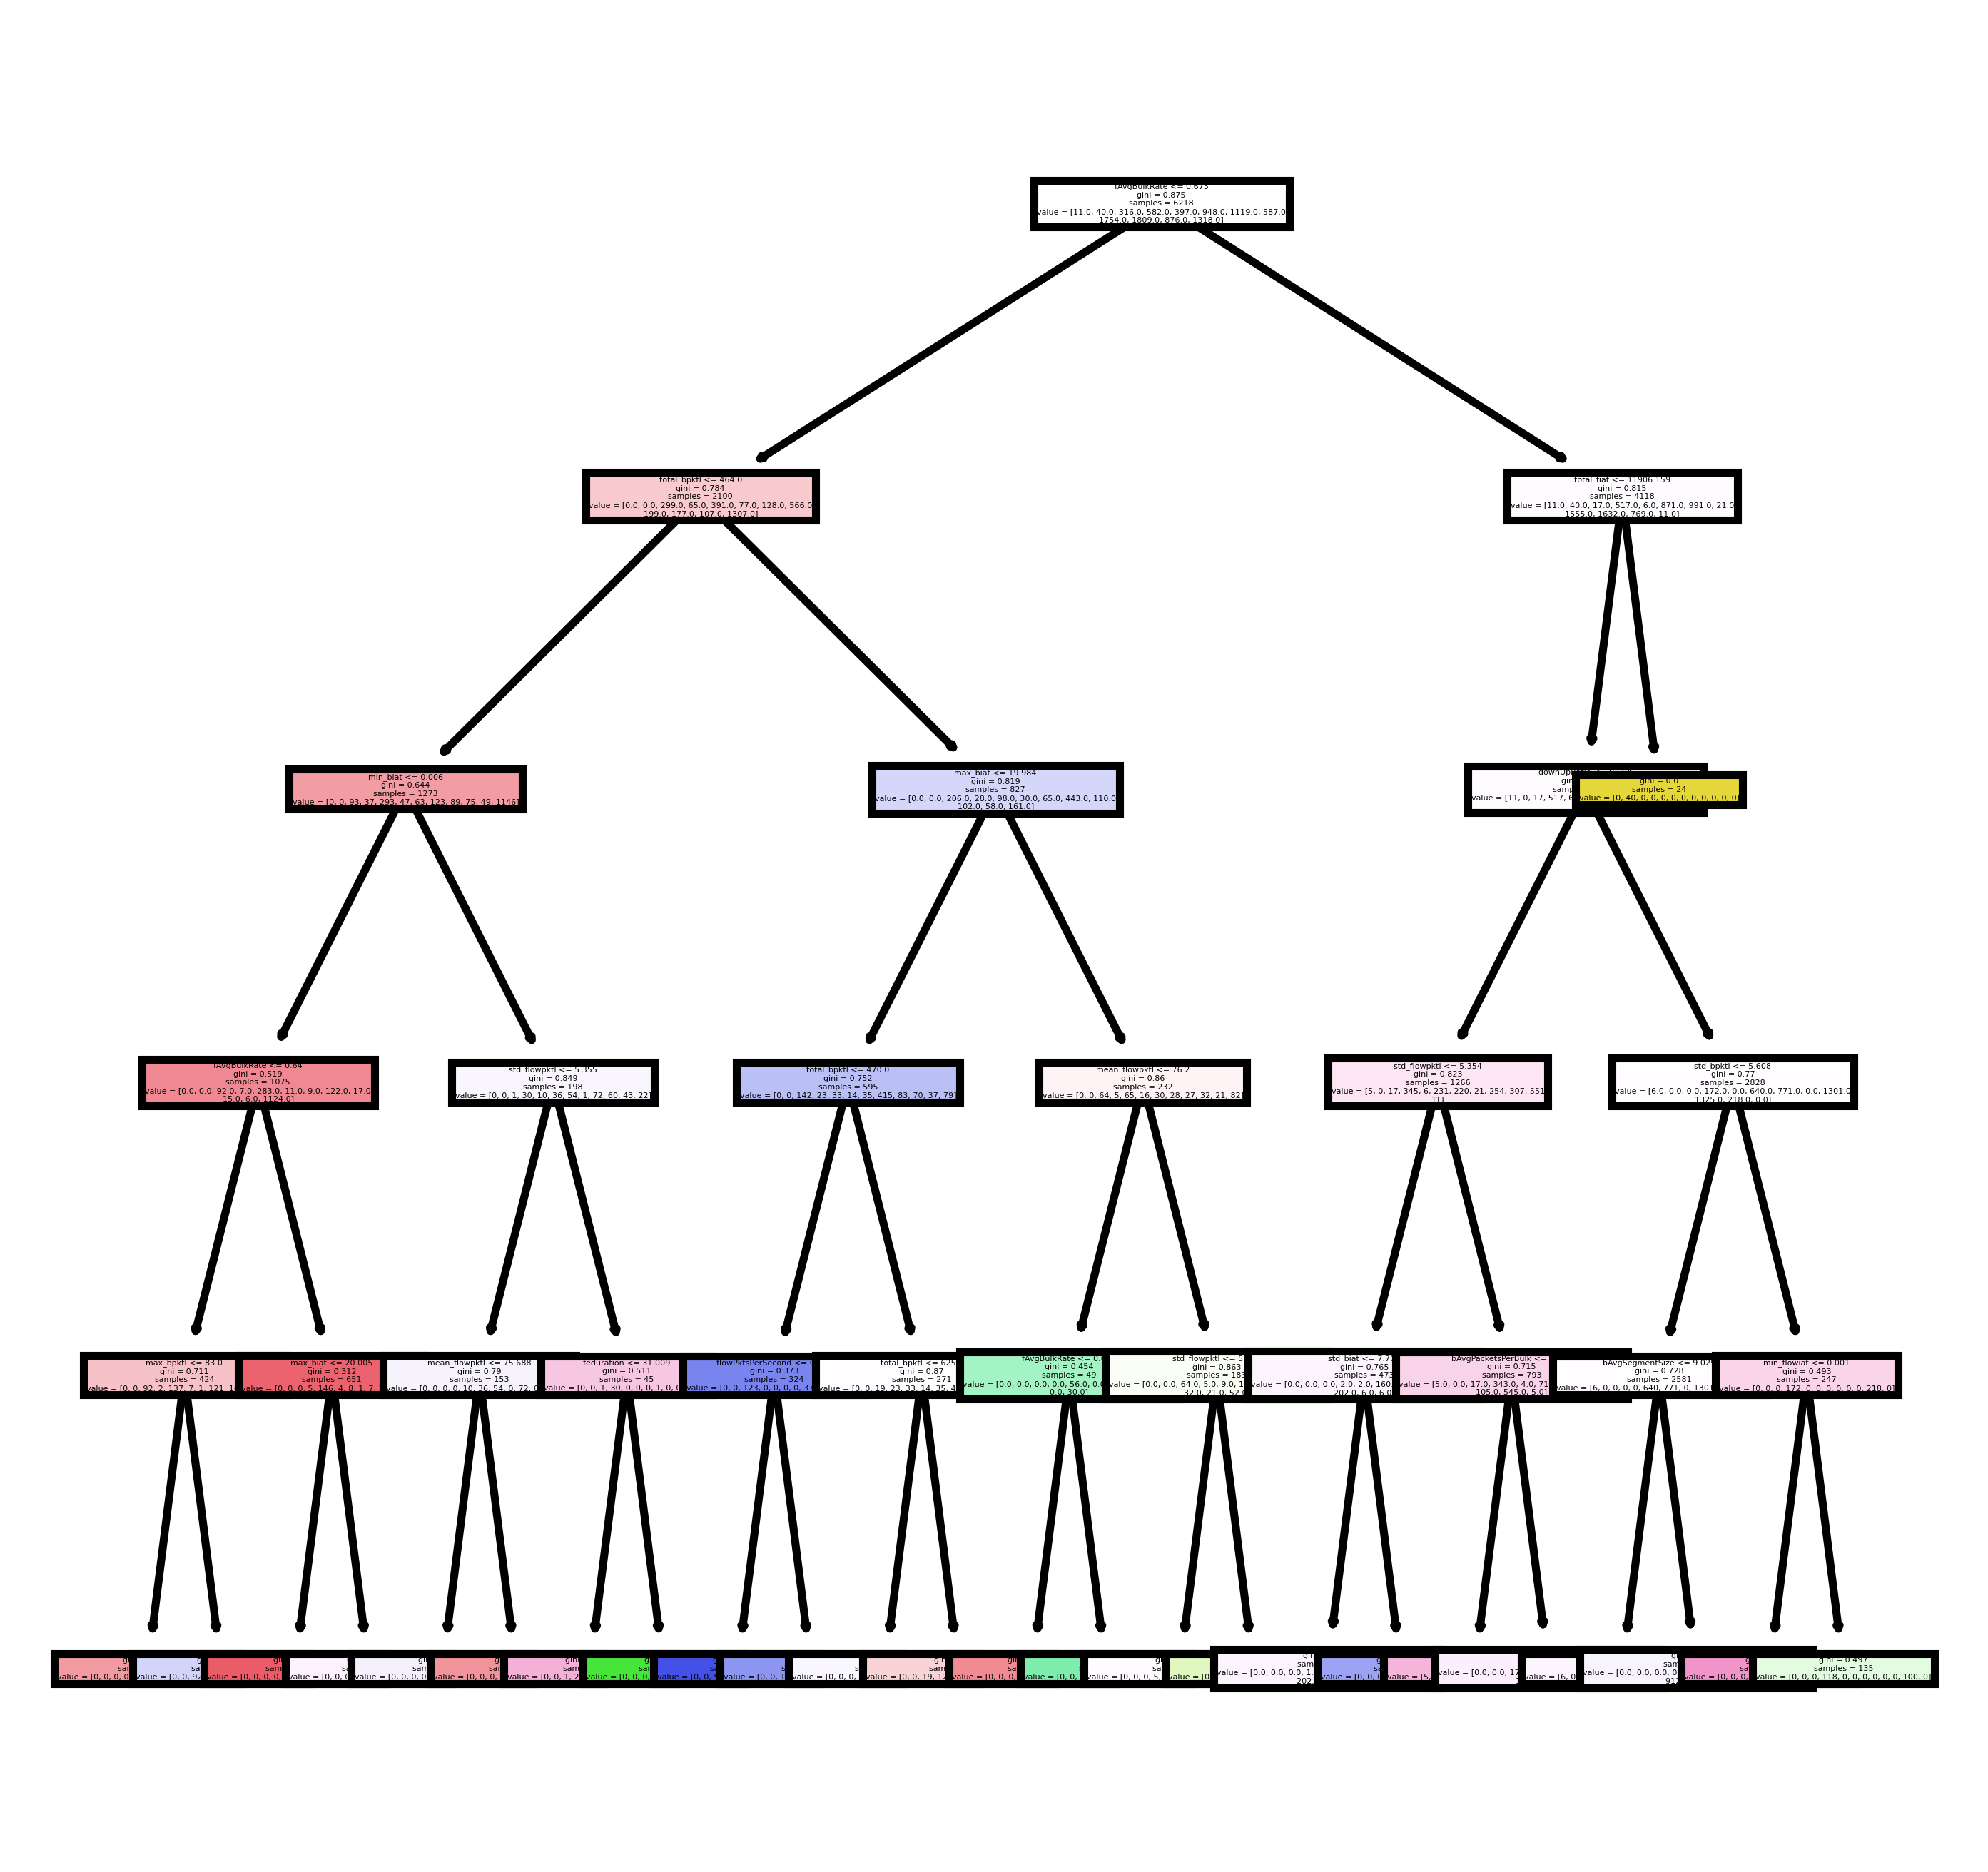

In [7]:
from sklearn import tree
rf=best_model
fn=X_train.columns
# cn='target'
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf.estimators_[0],
               feature_names = fn, 
            #    class_names=cn,
               filled = True);
fig.savefig('views/rf_individualtree.png')

In [8]:
display(df_results)

,model,best_parameters,timeout,number_packets,output_date,accuracy,precision,recall,confusion_matrix,tpr,fpr,average_prediction_time,standard_deviation_prediction_time,average_throughput,standard_deviation_throughput,average_total_prediction_time,standard_deviation_total_prediction_time,average_total_throughput,standard_deviation_total_throughput
0,Random Forest,"{'max_depth': 5, 'max_features': 'sqrt', 'n_es...",30,full,2024-07-16 16:46:01,0.559597,0.677678,0.559597,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 18,...",0.549244,0.040978,0.011248,0.001689,88.903603,13.308117,1.674809,0.722756,0.597083,0.480469


In [9]:
X_test.shape

(2711, 64)